In [1]:
import os
import re
import sys
import dataset
from scipy.stats import nanmean
from scipy.optimize import curve_fit
import math
#import numpy
#import matplotlib.pyplot as plt
%pylab inline


Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [2]:
def au2kcal(x):
    if type(x) is not list: 
        x = [ x ]
        islist=0
        if x==[None]:
            return None
    else:
        islist=1
    for i in range(len(x)):
        x[i]=x[i]*627.50960803
    if not islist:
        x=x[0]
    return x

In [3]:
def extapolateTau(taus,energies,errors):
    def func(x, a,b):
        if type(x) is not list: 
            x = [ x ]
            islist=0
        else:
            islist=1
        res=[0]*len(x)
        for i in range(len(x)):
            res[i]=a*x[i]+b
        if islist==0:
            res=res[0]
        return res
    
    popt, pcov = curve_fit(func, taus, energies, sigma=errors, absolute_sigma=True, check_finite=True)
    perr = np.sqrt(np.diag(pcov))
    
#    plt.figure()
#    plt.errorbar(taus, au2kcal(energies), yerr=au2kcal(errors), fmt='ro')
#    t=arange(0.0, 0.01, 0.001)
#    s = au2kcal(func(t,popt[0],popt[1]))
#    plt.plot(t, s)
#    plt.autoscale(enable=True, axis=u'both', tight=True)
#    ax=plt.gca().get_ybound()
#    plt.ylim([ax[0],ax[0]+10])
#    plt.show()
    
    return[popt[1],perr[1]]

In [4]:
def extapolateTauQuad(taus,energies,errors):
    def func(x, a,b,c):
        if type(x) is not list: 
            x = [ x ]
            islist=0
        else:
            islist=1
        res=[0]*len(x)
        for i in range(len(x)):
            res[i]=a*x[i]**2+b*x[i]+c
        if islist==0:
            res=res[0]
        return res
    
    popt, pcov = curve_fit(func, taus, energies, sigma=errors, absolute_sigma=True, check_finite=True)
    perr = np.sqrt(np.diag(pcov))
    
#    plt.figure()
#    plt.errorbar(taus, au2kcal(energies), yerr=au2kcal(errors), fmt='ro')
#    t=arange(0.0, 0.01, 0.001)
#    s = au2kcal(func(t,popt[0],popt[1],popt[2]))
#    plt.plot(t, s)
#    plt.autoscale(enable=True, axis=u'both', tight=True)
#    ax=plt.gca().get_ybound()
#    plt.ylim([ax[0],ax[0]+10])
#    plt.show()
 
    return[popt[2],perr[2]]

In [5]:
moleculeDB='3dMLBE20_JTCT11-2036_2015.db' #/home/kdd/test/3dMLBE20_JTCT11-2036_2015.db'
jobDB='jobDB.db'#/home/kdd/test/jobDB.db'
#get list of compounds
with dataset.connect('sqlite:///'+moleculeDB) as DB3d:
    compoundList=[]
    compoundListMol=[]
    for table in ['atoms', 'dimers']:
        for molecule in DB3d[table]:
            if table=='atoms':
                compoundList.append(molecule['atom'])
            elif table=='dimers':
                compoundList.append(molecule['compound'])
                compoundListMol.append(molecule['compound'])
compoundListMol=['VH','CrH','FeH','CoH','CuH','ZnH','VO','CrO','ZnO','MnS','ZnS','TiCl','VCl','CrCl','MnCl','FeCl','CoCl','NiCl','CuCl','ZnCl']
compoundList=['Ti','V','Cr','Mn','Fe','Co','Ni','Cu','Zn','H','O','S','Cl']+compoundListMol

In [6]:
dfttypList=['none','PBE','B3LYP','B97-1','M06']
typList=['DFT','EMIN_casino','DMC_casino', 'EMIN_qwalk','DMC_qwalk']
dtList=[0.002,0.005,0.008]
energy=numpy.zeros((len(compoundList),len(dfttypList)*len(typList)))
error=numpy.zeros((len(compoundList),len(dfttypList)*len(typList)))
variance=numpy.zeros((len(compoundList),len(dfttypList)*len(typList)))
dissocEnergy=numpy.zeros((len(compoundListMol),len(dfttypList)*len(typList)))
dissocError=numpy.zeros((len(compoundListMol),len(dfttypList)*len(typList)))
dissocEnergyQuad=numpy.zeros((len(compoundListMol),len(dfttypList)*len(typList)))
dissocErrorQuad=numpy.zeros((len(compoundListMol),len(dfttypList)*len(typList)))
dissocEnergyExp=numpy.zeros(len(compoundListMol))
energyExtrap=numpy.zeros((len(compoundList),3*len(dfttypList)*len(typList)))
errorExtrap=numpy.zeros((len(compoundList),3*len(dfttypList)*len(typList)))
dissocEnergyExtrap=numpy.zeros((len(compoundListMol),3*len(dfttypList)*len(typList)))
dissocErrorExtrap=numpy.zeros((len(compoundListMol),3*len(dfttypList)*len(typList)))


In [7]:
#get dft energy results 
typ=0
for compound in range(len(compoundList)):
    for dfttyp in range(len(dfttypList)):
        jobRecord={}
        jobRecord['dfttyp']=dfttypList[dfttyp]
        jobRecord['scftyp']='UHF'
        jobRecord['basisXMLFiles']='["BFD_Library_noPseudoH.xml", "aug-cc-pVTZ-DK_Diffuse.xml"]'
        jobRecord['basisNames']='["vtz", "aug-cc-pVTZ-DK_Diffuse"]'
        jobRecord['executingProgram']='gamessCasinoInt'
        jobRecord['compound']=compoundList[compound]        

        with dataset.connect('sqlite:///'+jobDB) as DBdata:
            result=DBdata['data'].find_one(**jobRecord)

        if result['status']=='Done':
            energy[compound,dfttyp+len(dfttypList)*typ]=au2kcal(result['energy'])
            error[compound,dfttyp+len(dfttypList)*typ]=au2kcal(result['error'])
            variance[compound,dfttyp+len(dfttypList)*typ]=result['variance']
        else:
            energy[compound,dfttyp+len(dfttypList)*typ]=None
            error[compound,dfttyp+len(dfttypList)*typ]=0.0
            variance[compound,dfttyp+len(dfttypList)*typ]=None


In [8]:
#get emin energy results
typ=1
for compound in range(len(compoundList)):
    for dfttyp in range(len(dfttypList)):
        jobRecord={}
        jobRecord['dfttyp']=dfttypList[dfttyp]
        jobRecord['scftyp']='UHF'
        jobRecord['basisXMLFiles']='["BFD_Library_noPseudoH.xml", "aug-cc-pVTZ-DK_Diffuse.xml"]'
        jobRecord['basisNames']='["vtz", "aug-cc-pVTZ-DK_Diffuse"]'
        jobRecord['executingProgram']='casino'
        jobRecord['qmctyp']='vmc'
        jobRecord['compound']=compoundList[compound]
        jobRecord['Nu']=4
        jobRecord['Nchi']=4
        jobRecord['Nf']=2
        jobRecord['slaterGeneratingCode']='gamessCasinoInt'

        with dataset.connect('sqlite:///'+jobDB) as DBdata:
            results=DBdata['data'].find(**jobRecord)

        for result in results:
            
            if result['jastrowFrom']==-1:
                continue
            elif '_true' in result['symmetry']:
                continue
            else:
                with dataset.connect('sqlite:///'+jobDB) as DBdata:
                    jastrowFrom=DBdata['data'].find_one(id=result['jastrowFrom'])
                if jastrowFrom['qmctyp']!='emin':
                    continue
                with dataset.connect('sqlite:///'+jobDB) as DBdata:
                    jastrowFrom2=DBdata['data'].find_one(id=jastrowFrom['jastrowFrom'])
                if jastrowFrom2['qmctyp']!='varmin':
                    continue       

            if energy[compound,dfttyp+len(dfttypList)*typ]!=0:
                sys.exit("something wrong here: two energies found for one entry.")
            if result['status']=='Done':
                energy[compound,dfttyp+len(dfttypList)*typ]=au2kcal(result['energy'])
                error[compound,dfttyp+len(dfttypList)*typ]=au2kcal(result['error'])
                variance[compound,dfttyp+len(dfttypList)*typ]=result['variance']
            else:
                energy[compound,dfttyp+len(dfttypList)*typ]=None
                error[compound,dfttyp+len(dfttypList)*typ]=0.0
                variance[compound,dfttyp+len(dfttypList)*typ]=None

In [9]:
#get emin energy results qwalk
typ=3
for compound in range(len(compoundList)):
    for dfttyp in range(len(dfttypList)):
        jobRecord={}
        jobRecord['dfttyp']=dfttypList[dfttyp]
        jobRecord['scftyp']='UHF'
        jobRecord['basisXMLFiles']='["BFD_Library_noPseudoH.xml", "aug-cc-pVTZ-DK_Diffuse.xml"]'
        jobRecord['basisNames']='["vtz", "aug-cc-pVTZ-DK_Diffuse"]'
        jobRecord['executingProgram']='qwalk'
        jobRecord['qmctyp']='vmc'
        jobRecord['compound']=compoundList[compound]
        jobRecord['Nu']=3
        jobRecord['Nchi']=4
        jobRecord['Nf']=4
        jobRecord['slaterGeneratingCode']='gamessCasinoInt'

        with dataset.connect('sqlite:///'+jobDB) as DBdata:
            results=DBdata['data'].find(**jobRecord)

        for result in results:
            if result['jastrowFrom']==-1:
                continue
            elif '_true' in result['symmetry']:
                continue
            else:
                with dataset.connect('sqlite:///'+jobDB) as DBdata:
                    jastrowFrom=DBdata['data'].find_one(id=result['jastrowFrom'])
                if jastrowFrom['qmctyp']!='emin':
                    continue
                with dataset.connect('sqlite:///'+jobDB) as DBdata:
                    jastrowFrom2=DBdata['data'].find_one(id=jastrowFrom['jastrowFrom'])
                if jastrowFrom2['qmctyp']!='varmin':
                    continue
                    

            if energy[compound,dfttyp+len(dfttypList)*typ]!=0:
                sys.exit("something wrong here: two energies found for one entry.")
            if result['status']=='Done':
                energy[compound,dfttyp+len(dfttypList)*typ]=au2kcal(result['energy'])
                error[compound,dfttyp+len(dfttypList)*typ]=au2kcal(result['error'])
                variance[compound,dfttyp+len(dfttypList)*typ]=result['variance']
            else:
                energy[compound,dfttyp+len(dfttypList)*typ]=None
                error[compound,dfttyp+len(dfttypList)*typ]=0.0
                variance[compound,dfttyp+len(dfttypList)*typ]=None

In [10]:
#get dmc energy results extrapolated to tau=0 and at tau=[0.002,0.005,0.008]
typ=2
for compound in range(len(compoundList)):
    for dfttyp in range(len(dfttypList)):
        jobRecord={}
        jobRecord['dfttyp']=dfttypList[dfttyp]
        jobRecord['scftyp']='UHF'
        jobRecord['basisXMLFiles']='["BFD_Library_noPseudoH.xml", "aug-cc-pVTZ-DK_Diffuse.xml"]'
        jobRecord['basisNames']='["vtz", "aug-cc-pVTZ-DK_Diffuse"]'
        jobRecord['executingProgram']='casino'
        jobRecord['qmctyp']='vmc_dmc'
        jobRecord['compound']=compoundList[compound]
        jobRecord['Nu']=4
        jobRecord['Nchi']=4
        jobRecord['Nf']=2
        jobRecord['slaterGeneratingCode']='gamessCasinoInt'

        with dataset.connect('sqlite:///'+jobDB) as DBdata:
            results=DBdata['data'].find(**jobRecord)

        resultsExtrap=[]
        for result in results:
            if result['jastrowFrom']==-1:
                continue
            elif '_true' in result['symmetry']:
                continue
            else:
                with dataset.connect('sqlite:///'+jobDB) as DBdata:
                    jastrowFrom=DBdata['data'].find_one(id=result['jastrowFrom'])
                if jastrowFrom['qmctyp']!='emin':
                    continue
                with dataset.connect('sqlite:///'+jobDB) as DBdata:
                    jastrowFrom2=DBdata['data'].find_one(id=jastrowFrom['jastrowFrom'])
                if jastrowFrom2['qmctyp']!='varmin':
                    continue
            resultsExtrap.append(result)
            
        for i in reversed(range(len(resultsExtrap))):
            if not resultsExtrap[i]['status'] in ["Done","LargeErrorbar2", "BadReblock"]:
                resultsExtrap.pop(i)
                
        if len(resultsExtrap)<2:
            energy[compound,dfttyp+len(dfttypList)*typ]=None
            error[compound,dfttyp+len(dfttypList)*typ]=0.0
        else: #extrapolate to zero Time
#            print([resultsExtrap[i]['dt'] for i in range(len(resultsExtrap))])
#            print([resultsExtrap[i]['energy'] for i in range(len(resultsExtrap))])
#            print([resultsExtrap[i]['error'] for i in range(len(resultsExtrap))])
            [energy[compound,dfttyp+len(dfttypList)*typ], error[compound,dfttyp+len(dfttypList)*typ]]=\
            au2kcal(extapolateTau([resultsExtrap[i]['dt'] for i in range(len(resultsExtrap))],
                         [resultsExtrap[i]['energy'] for i in range(len(resultsExtrap))],
                         [resultsExtrap[i]['error'] for i in range(len(resultsExtrap))]))
        #non extrapolated results
        energyExtrap[compound,len(dtList)*(dfttyp+len(dfttypList)*typ):len(dtList)*(dfttyp+len(dfttypList)*typ)+len(dtList)]=None
        errorExtrap[compound,len(dtList)*(dfttyp+len(dfttypList)*typ):len(dtList)*(dfttyp+len(dfttypList)*typ)+len(dtList)]=None
        for i in range(len(resultsExtrap)):
            if  resultsExtrap[i]['dt']==dtList[0]:
                dt=0
            elif resultsExtrap[i]['dt']==dtList[1]:
                dt=1
            elif resultsExtrap[i]['dt']==dtList[2]:
                dt=2
            energyExtrap[compound,len(dtList)*(dfttyp+len(dfttypList)*typ)+dt]=au2kcal(resultsExtrap[i]['energy'])
            errorExtrap[compound,len(dtList)*(dfttyp+len(dfttypList)*typ)+dt]=au2kcal(resultsExtrap[i]['error'])
       

In [11]:
#get dmc energy results extrapolated to tau=0 and at tau=[0.002,0.005,0.008]
typ=4
for compound in range(len(compoundList)):
    for dfttyp in range(len(dfttypList)):
        jobRecord={}
        jobRecord['dfttyp']=dfttypList[dfttyp]
        jobRecord['scftyp']='UHF'
        jobRecord['basisXMLFiles']='["BFD_Library_noPseudoH.xml", "aug-cc-pVTZ-DK_Diffuse.xml"]'
        jobRecord['basisNames']='["vtz", "aug-cc-pVTZ-DK_Diffuse"]'
        jobRecord['executingProgram']='qwalk'
        jobRecord['qmctyp']='vmc_dmc'
        jobRecord['compound']=compoundList[compound]
        jobRecord['Nu']=3
        jobRecord['Nchi']=4
        jobRecord['Nf']=4
        jobRecord['slaterGeneratingCode']='gamessCasinoInt'

        with dataset.connect('sqlite:///'+jobDB) as DBdata:
            results=DBdata['data'].find(**jobRecord)

        resultsExtrap=[]
        for result in results:
            if result['jastrowFrom']==-1:
                continue
            elif '_true' in result['symmetry']:
                continue
            else:
                with dataset.connect('sqlite:///'+jobDB) as DBdata:
                    jastrowFrom=DBdata['data'].find_one(id=result['jastrowFrom'])
                if jastrowFrom['qmctyp']!='emin':
                    continue
                with dataset.connect('sqlite:///'+jobDB) as DBdata:
                    jastrowFrom2=DBdata['data'].find_one(id=jastrowFrom['jastrowFrom'])
                if jastrowFrom2['qmctyp']!='varmin':
                    continue
            resultsExtrap.append(result)
            
        for i in reversed(range(len(resultsExtrap))):
            if not resultsExtrap[i]['status'] in ["Done","LargeErrorbar2", "BadReblock"]:
                resultsExtrap.pop(i)
                
        if len(resultsExtrap)<2:
            energy[compound,dfttyp+len(dfttypList)*typ]=None
            error[compound,dfttyp+len(dfttypList)*typ]=0.0
        else: #extrapolate to zero Time
#            print([resultsExtrap[i]['dt'] for i in range(len(resultsExtrap))])
#            print([resultsExtrap[i]['energy'] for i in range(len(resultsExtrap))])
#            print([resultsExtrap[i]['error'] for i in range(len(resultsExtrap))])
            [energy[compound,dfttyp+len(dfttypList)*typ], error[compound,dfttyp+len(dfttypList)*typ]]=\
            au2kcal(extapolateTau([resultsExtrap[i]['dt'] for i in range(len(resultsExtrap))],
                         [resultsExtrap[i]['energy'] for i in range(len(resultsExtrap))],
                         [resultsExtrap[i]['error'] for i in range(len(resultsExtrap))]))
        #non extrapolated results
        energyExtrap[compound,len(dtList)*(dfttyp+len(dfttypList)*typ):len(dtList)*(dfttyp+len(dfttypList)*typ)+len(dtList)]=None
        errorExtrap[compound,len(dtList)*(dfttyp+len(dfttypList)*typ):len(dtList)*(dfttyp+len(dfttypList)*typ)+len(dtList)]=None
        for i in range(len(resultsExtrap)):
            if  resultsExtrap[i]['dt']==dtList[0]:
                dt=0
            elif resultsExtrap[i]['dt']==dtList[1]:
                dt=1
            elif resultsExtrap[i]['dt']==dtList[2]:
                dt=2
            energyExtrap[compound,len(dtList)*(dfttyp+len(dfttypList)*typ)+dt]=au2kcal(resultsExtrap[i]['energy'])
            errorExtrap[compound,len(dtList)*(dfttyp+len(dfttypList)*typ)+dt]=au2kcal(resultsExtrap[i]['error'])

/opt/rh/python27/root/usr/lib64/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


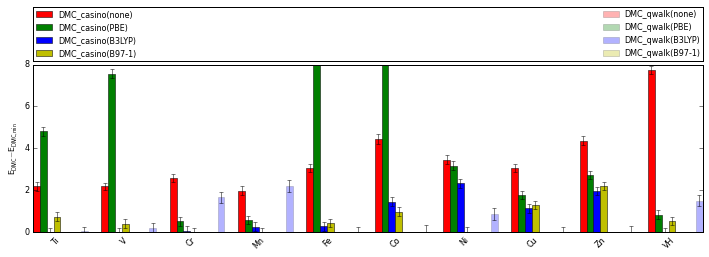

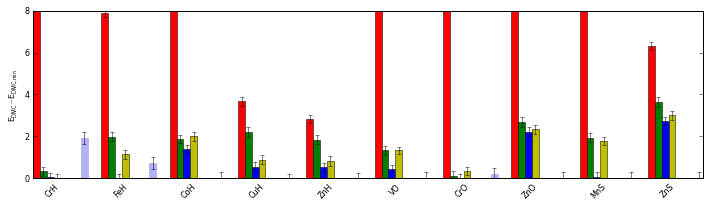

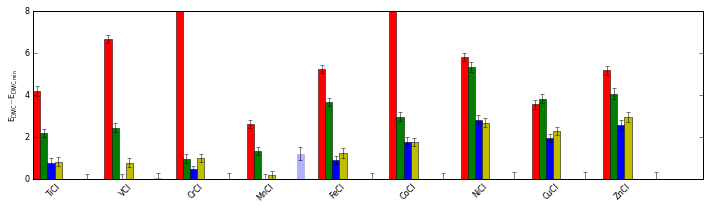

In [12]:
#plot DMC energy results results vs min DMC energy 
typForPlotList=[2,4]
molPerPlot=min(10, len(compoundList))
colors=['r','g','b','y','c','m']
opac=[1,0.3,0.3]
error_config = {'ecolor': '0.0', 'capsize': 2}
barwidth=1/(len(dfttypList)*len(typForPlotList)*1.0)
#barwidth=0.2
index = numpy.arange(molPerPlot)

j=0
for i in range(len(compoundList)):
    if compoundList[i] in ['H', 'O','S', 'Cl']:
        continue
    if j%molPerPlot==0:
        mycompoundList=[]
        fig, ax = plt.subplots(figsize=(12, 3))
    mycompoundList.append(compoundList[i])
    for tfp in range(len(typForPlotList)):
        typForPlot=typForPlotList[tfp]
        for dft in [0,1,2,3]:
            #print("{} {}".format(compoundList[i], dfttypList[dft]))
            #print("{}+/-{}".format(energy[i,typForPlot*(len(dfttypList))+dft]-min([nanmin(energy[i,tt*(len(dfttypList))+0:tt*(len(dfttypList))+5]) for tt in typForPlotList]), error[i,typForPlot*(len(dfttypList))+dft]))
            if j==0:
                rects=plt.bar(j%molPerPlot+(len(dfttypList)*tfp+dft)*barwidth,
                              (energy[i,typForPlot*(len(dfttypList))+dft]-min([nanmin(energy[i,tt*(len(dfttypList))+0:tt*(len(dfttypList))+5]) for tt in typForPlotList])), 
                              barwidth,
                              label=typList[typForPlot]+"("+dfttypList[dft]+")",
                              color=colors[dft],
                              alpha=opac[tfp],
                              linewidth=0.5,
                             )
            else:
                rects=plt.bar(j%molPerPlot+(len(dfttypList)*tfp+dft)*barwidth,
                              (energy[i,typForPlot*(len(dfttypList))+dft]-min([nanmin(energy[i,tt*(len(dfttypList))+0:tt*(len(dfttypList))+5]) for tt in typForPlotList])), 
                              barwidth,
                              color=colors[dft],
                              alpha=opac[tfp],
                              linewidth=0.5,
                             )
            errorb=plt.errorbar(j%molPerPlot+(len(dfttypList)*tfp+dft)*barwidth+barwidth/2.0, 
                                (energy[i,typForPlot*(len(dfttypList))+dft]-min([nanmin(energy[i,tt*(len(dfttypList))+0:tt*(len(dfttypList))+5]) for tt in typForPlotList])),
                                yerr=error[i,typForPlot*(len(dfttypList))+dft],
                                ecolor='k',
                                elinewidth=0.5, capsize=2
                               )
            plt.xticks(index+0.4, mycompoundList,  rotation=45, ha='right', fontsize=8)                                                                                                   
            plt.ylabel(r'$\mathrm{\mathsf{E_{DMC}-E_{DMC, min}}}$', fontsize=8)#, fontsize=12) 
            if j<molPerPlot:
                plt.legend(loc=3, bbox_to_anchor=(0., 1.02, 1., .102), ncol=2, mode="expand", borderaxespad=0., prop={'size':8})#,bbox_to_anchor=(1.05, 1), prop={'size':8})
            plt.ylim([0,6])
            plt.yticks(np.arange(0, 10, 2.0), fontsize=8)
            ax.xaxis.set_tick_params(width=0)
            #plt.autoscale(enable=True, axis=u'both', tight=True)
            if j%molPerPlot==molPerPlot-1 or i==len(compoundList)-1:
                fig.set_size_inches(12,3)
                #plt.savefig('absE'+str(int(j/molPerPlot))+'.svg', format='svg', dpi=300)
    j+=1




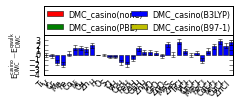

In [13]:
#plot DMC energy results for casino vs  DMC energy for qwalk for DMC(B3LYP)
typForPlotList=[2]
RefTypForPlotList=[4]
molPerPlot=min(33, len(compoundList))
colors=['r','g','b','y','c','m']
opac=[1,0.3,0.3]
error_config = {'ecolor': '0.0', 'capsize': 2}
barwidth=1/(len(typForPlotList)*1.4)
#barwidth=0.2
index = numpy.arange(molPerPlot)

j=0
for i in range(len(compoundList)):
    #if compoundList[i] in ['H', 'O','S', 'Cl']:
    #    continue
    if j%molPerPlot==0:
        mycompoundList=[]
        fig, ax = plt.subplots(figsize=(12, 3))
    mycompoundList.append(compoundList[i])
    for tfp in range(len(typForPlotList)):
        typForPlot=typForPlotList[tfp]
        RefTypForPlot=RefTypForPlotList[tfp]
        for dft in [0,1,2,3]:
            #print("{} {}".format(compoundList[i], dfttypList[dft]))
            #print("{}+/-{}".format(energy[i,typForPlot*(len(dfttypList))+dft]-min([nanmin(energy[i,tt*(len(dfttypList))+0:tt*(len(dfttypList))+5]) for tt in typForPlotList]), error[i,typForPlot*(len(dfttypList))+dft]))
            if j==0:
                rects=plt.bar(j%molPerPlot+(len(dfttypList)*tfp)*barwidth,
                              (energy[i,typForPlot*(len(dfttypList))+dft]-energy[i,RefTypForPlot*(len(dfttypList))+dft]), 
                              barwidth,
                              label=typList[typForPlot]+"("+dfttypList[dft]+")",
                              color=colors[dft],
                              alpha=opac[tfp],
                              linewidth=0.5,
                             )
            else:
                rects=plt.bar(j%molPerPlot+(len(dfttypList)*tfp)*barwidth,
                              (energy[i,typForPlot*(len(dfttypList))+dft]-energy[i,RefTypForPlot*(len(dfttypList))+dft]), 
                              barwidth,
                              color=colors[dft],
                              alpha=opac[tfp],
                              linewidth=0.5,
                             )
            errorb=plt.errorbar(j%molPerPlot+(len(dfttypList)*tfp)*barwidth+barwidth/2.0, 
                                (energy[i,typForPlot*(len(dfttypList))+dft]-energy[i,RefTypForPlot*(len(dfttypList))+dft]),
                                yerr=error[i,typForPlot*(len(dfttypList))+dft]+error[i,RefTypForPlot*(len(dfttypList))+dft],
                                ecolor='k',
                                elinewidth=0.5, capsize=2
                               )
            plt.xticks(index+0.4, mycompoundList,  rotation=45, ha='right', fontsize=8)                                                                                                   
            plt.ylabel(r'$\mathrm{\mathsf{E_{DMC}^{casino}-E_{DMC}^{qwalk}}}$', fontsize=8)#, fontsize=12) 
            if j<molPerPlot:
                plt.legend(loc=3, bbox_to_anchor=(0., 1.02, 1., .102), ncol=2, mode="expand", borderaxespad=0., prop={'size':8})#,bbox_to_anchor=(1.05, 1), prop={'size':8})
            plt.ylim([-4,4])
            plt.yticks(np.arange(-4, 4, 1.0), fontsize=8)
            ax.xaxis.set_tick_params(width=0)
            #plt.autoscale(enable=True, axis=u'both', tight=True)
            if j%molPerPlot==molPerPlot-1 or i==len(compoundList)-1:
                #fig.set_size_inches(12,3)
                #plt.savefig('absE_casinoVsQwalk'+str(int(j/molPerPlot))+'.svg', format='svg', dpi=300)
                fig.set_size_inches(3.4,0.7)
                plt.savefig('absE_casinoVsQwalk'+str(int(j/molPerPlot))+'.svg', format='svg', dpi=600)
    j+=1


In [14]:
for i in range(len(compoundList)):
    print compoundList[i]
    print(" {}   {}".format(energy[i,2*len(dfttypList)+2], energy[i,4*len(dfttypList)+2]))

Ti
 -36516.2018095   -36516.1686279
V
 -44894.7549554   -44894.5828878
Cr
 -54529.5087108   -54527.9238219
Mn
 -65449.3715524   -65447.417266
Fe
 -77689.5837845   -77689.8511722
Co
 -91434.3233199   -91435.7763411
Ni
 -106744.093748   -106745.550949
Cu
 -123765.723196   -123766.848852
Zn
 -142472.004879   -142473.961305
H
 -313.742754443   -313.759653544
O
 -9972.6809918   -9972.66255501
S
 -6357.1545931   -6356.71222764
Cl
 -9394.64514819   -9394.21939766
VH
 -45266.2683415   -45264.7661994
CrH
 -54893.689671   -54891.8234543
FeH
 -78043.9364011   -78043.1918837
CoH
 -91797.57017   -91798.9447405
CuH
 -124141.182857   -124141.723177
ZnH
 -142812.079549   -142812.591369
VO
 -55009.4826149   -55009.9391621
CrO
 -64596.4342373   -64596.2229049
ZnO
 -152474.091105   -152476.312869
MnS
 -71867.4471436   -71867.512124
ZnS
 -148857.64399   -148860.369142
TiCl
 -46007.8720874   -46008.6366959
VCl
 -54387.8571952   -54387.8543721
CrCl
 -64011.499806   -64011.9360369
MnCl
 -74928.3816854   -749

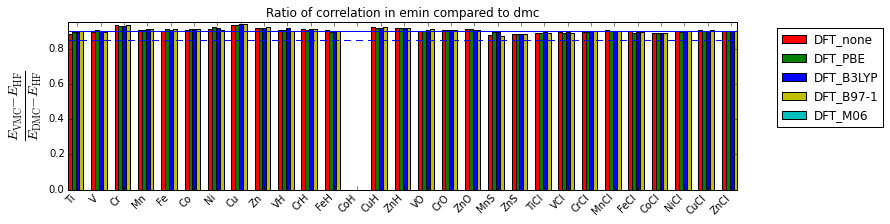

In [15]:
#plot ratio of correl in emin, dmc for casino
typemin=1
typdmc=2
molPerPlot=min(33, len(compoundList))
colors=['r','g','b','y','c','m']
opac=[1,0.3,0.3]
error_config = {'ecolor': '0.3'}
barwidth=1/(len(dfttypList)*1.2)
#barwidth=0.2
index = numpy.arange(molPerPlot)

for i in range(int(ceil(float(len(compoundList))/molPerPlot))):
    a=i*molPerPlot
    b=min((i+1)*molPerPlot, len(compoundList))
    fig, ax = plt.subplots(figsize=(12, 3))
    mycompoundList=[]
    for j in range(len(dfttypList)):
        shift=0
        first=1
        for ind in range(b-a):
            if compoundList[a+ind]in ['H', 'O','S', 'Cl']:
                shift+=-1
                continue
            if j==0:
                mycompoundList.append(compoundList[a+ind])
            if first:
                rects=plt.bar(ind+shift+j*barwidth,
                          (energy[a+ind,typemin*(len(dfttypList))+j]-energy[a+ind,0])/(energy[a+ind,typdmc*(len(dfttypList))+j]-energy[a+ind,0]), 
                          barwidth,
                          label=typList[i]+"_"+dfttypList[j],
                          color=colors[j],
                          alpha=opac[i])
                first=0
            else:
                 rects=plt.bar(ind+shift+j*barwidth,
                          (energy[a+ind,typemin*(len(dfttypList))+j]-energy[a+ind,0])/(energy[a+ind,typdmc*(len(dfttypList))+j]-energy[a+ind,0]), 
                          barwidth,
                          color=colors[j],
                          alpha=opac[i])   
        plt.axhline(0.9)
        plt.axhline(0.85, linestyle='dashed')
        plt.axhline(0.95, linestyle='dashed')
        plt.xticks(index+0.4, mycompoundList,  rotation=45, ha='right')
    #plt.xlabel('Molecules, Methods')                                                                                                     
    plt.ylabel(r'${\frac{E_\mathrm{VMC}-E_\mathrm{HF}}{E_\mathrm{DMC}-E_\mathrm{HF}}}$', fontsize=20) 
    plt.title('Ratio of correlation in emin compared to dmc')                                                                                                                                                                             
    plt.legend(loc=2,bbox_to_anchor=(1.05, 1))#, prop={'size':10})
    plt.ylim([0,1])
    plt.autoscale(enable=True, axis=u'both', tight=True)

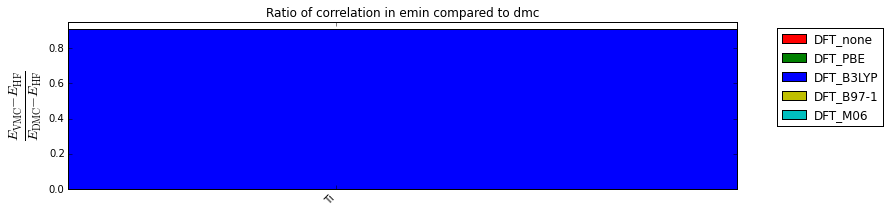

In [16]:
#plot ratio of correl in emin, dmc for qwalk
typemin=3
typdmc=4
molPerPlot=min(33, len(compoundList))
colors=['r','g','b','y','c','m']
opac=[1,0.3,0.3]
error_config = {'ecolor': '0.3'}
barwidth=1/(len(dfttypList)*1.2)
#barwidth=0.2
index = numpy.arange(molPerPlot)

for i in range(int(ceil(float(len(compoundList))/molPerPlot))):
    a=i*molPerPlot
    b=min((i+1)*molPerPlot, len(compoundList))
    fig, ax = plt.subplots(figsize=(12, 3))
    mycompoundList=[]
    for j in range(len(dfttypList)):
        shift=0
        first=1
        for ind in range(b-a):
            if compoundList[a+ind]in ['H', 'O','S', 'Cl']:
                shift+=-1
                continue
            if j==0:
                mycompoundList.append(compoundList[a+ind])
            if first:
                rects=plt.bar(ind+shift+j*barwidth,
                          (energy[a+ind,typemin*(len(dfttypList))+j]-energy[a+ind,0])/(energy[a+ind,typdmc*(len(dfttypList))+j]-energy[a+ind,0]), 
                          barwidth,
                          label=typList[i]+"_"+dfttypList[j],
                          color=colors[j],
                          alpha=opac[i])
                first=0
            else:
                 rects=plt.bar(ind+shift+j*barwidth,
                          (energy[a+ind,typemin*(len(dfttypList))+j]-energy[a+ind,0])/(energy[a+ind,typdmc*(len(dfttypList))+j]-energy[a+ind,0]), 
                          barwidth,
                          color=colors[j],
                          alpha=opac[i])   
        plt.axhline(0.9)
        plt.axhline(0.85, linestyle='dashed')
        plt.axhline(0.95, linestyle='dashed')
        plt.xticks(index+0.4, mycompoundList,  rotation=45, ha='right')
    #plt.xlabel('Molecules, Methods')                                                                                                     
    plt.ylabel(r'${\frac{E_\mathrm{VMC}-E_\mathrm{HF}}{E_\mathrm{DMC}-E_\mathrm{HF}}}$', fontsize=20) 
    plt.title('Ratio of correlation in emin compared to dmc')                                                                                                                                                                             
    plt.legend(loc=2,bbox_to_anchor=(1.05, 1))#, prop={'size':10})
    plt.ylim([0,1])
    plt.autoscale(enable=True, axis=u'both', tight=True)

In [17]:
#get dissocE for DFT
typ=0
for compound in range(len(compoundListMol)):
                
    atoms=re.findall('[A-Z][^A-Z]*', compoundListMol[compound])
    
    experimentMol=DB3d['dimers'].find_one(compound=compoundListMol[compound])
    dissocEnergyExp[compound]=experimentMol['De(exp)[kcal/mol]']
    experimentAtom=[]
    for i in range(len(atoms)):
        experimentAtom.append(DB3d['atoms'].find_one(atom=atoms[i]))
                                       
                                       
    for dfttyp in range(len(dfttypList)):
        jobRecord={}
        jobRecord['dfttyp']=dfttypList[dfttyp]
        jobRecord['scftyp']='UHF'
        jobRecord['basisXMLFiles']='["BFD_Library_noPseudoH.xml", "aug-cc-pVTZ-DK_Diffuse.xml"]'
        jobRecord['basisNames']='["vtz", "aug-cc-pVTZ-DK_Diffuse"]'
        jobRecord['executingProgram']='gamessCasinoInt'
        jobRecord['compound']=compoundListMol[compound]   


        with dataset.connect('sqlite:///'+jobDB) as DBdata:
            resultMol=DBdata['data'].find_one(**jobRecord)
        
        resultAtom=[]
        for i in range(len(atoms)):
            jobRecord['compound']=atoms[i]
            with dataset.connect('sqlite:///'+jobDB) as DBdata:
                resultAtom.append(DBdata['data'].find_one(**jobRecord))
        if resultMol['status']=='Done' and all( [resultAtom[i]['status']=='Done' for i in range(len(atoms))]):
            dissocEnergy[compound,dfttyp+len(dfttypList)*typ]=au2kcal(-resultMol['energy']+sum(resultAtom[i]['energy'] for i in range(len(atoms))))
            #correct energy for SO coupling:
            dissocEnergy[compound,dfttyp+len(dfttypList)*typ]+=(-experimentMol['ESo(fromCAS)[kcal/mol]']+
                                             sum(experimentAtom[i]['E_SO [kcal/mol]'] for i in range(len(atoms))))
            dissocError[compound,dfttyp+len(dfttypList)*typ]=0.0
        else:
            dissocEnergy[compound, dfttyp+len(dfttypList)*typ]=None
            dissocError[compound,dfttyp+len(dfttypList)*typ]=0.0

            

In [18]:
#get dissocE for emin for casino
typ=1
for compound in range(len(compoundListMol)):
    atoms=re.findall('[A-Z][^A-Z]*', compoundListMol[compound])
    
    experimentMol=DB3d['dimers'].find_one(compound=compoundListMol[compound])
    dissocEnergyExp[compound]=experimentMol['De(exp)[kcal/mol]']
    experimentAtom=[]
    for i in range(len(atoms)):
        experimentAtom.append(DB3d['atoms'].find_one(atom=atoms[i]))
        
    for dfttyp in range(len(dfttypList)):
        jobRecord={}
        jobRecord['dfttyp']=dfttypList[dfttyp]
        jobRecord['scftyp']='UHF'
        jobRecord['basisXMLFiles']='["BFD_Library_noPseudoH.xml", "aug-cc-pVTZ-DK_Diffuse.xml"]'
        jobRecord['basisNames']='["vtz", "aug-cc-pVTZ-DK_Diffuse"]'
        jobRecord['executingProgram']='casino'
        jobRecord['qmctyp']='vmc'
        jobRecord['compound']=compoundListMol[compound]
        jobRecord['Nu']=4
        jobRecord['Nchi']=4
        jobRecord['Nf']=2
        jobRecord['slaterGeneratingCode']='gamessCasinoInt'

        with dataset.connect('sqlite:///'+jobDB) as DBdata:
            results=DBdata['data'].find(**jobRecord)

        for result in results:
            if result['jastrowFrom']==-1:
                continue
            elif '_true' in result['symmetry']:
                continue
            else:
                with dataset.connect('sqlite:///'+jobDB) as DBdata:
                    jastrowFrom=DBdata['data'].find_one(id=result['jastrowFrom'])
                if jastrowFrom['qmctyp']!='emin':
                    continue
                with dataset.connect('sqlite:///'+jobDB) as DBdata:
                    jastrowFrom2=DBdata['data'].find_one(id=jastrowFrom['jastrowFrom'])
                if jastrowFrom2['qmctyp']!='varmin':
                    continue
            resultMol=result
            
        resultAtom=[]
        for i in range(len(atoms)):
            jobRecord['compound']=atoms[i]
            with dataset.connect('sqlite:///'+jobDB) as DBdata:
                results=DBdata['data'].find(**jobRecord)
                for result in results:
                    if result['jastrowFrom']==-1:
                        continue
                    elif '_true' in result['symmetry']:
                        continue
                    else:
                        with dataset.connect('sqlite:///'+jobDB) as DBdata:
                            jastrowFrom=DBdata['data'].find_one(id=result['jastrowFrom'])
                        if jastrowFrom['qmctyp']!='emin':
                            continue
                        with dataset.connect('sqlite:///'+jobDB) as DBdata:
                            jastrowFrom2=DBdata['data'].find_one(id=jastrowFrom['jastrowFrom'])
                        if jastrowFrom2['qmctyp']!='varmin':
                            continue
                    resultAtom.append(result)
        
        if resultMol['status']=='Done' and all( [resultAtom[i]['status']=='Done' for i in range(len(atoms))]):
            dissocEnergy[compound,dfttyp+len(dfttypList)*typ]=au2kcal(-resultMol['energy']+sum(resultAtom[i]['energy'] for i in range(len(atoms))))
            #correct energy for SO coupling:
            dissocEnergy[compound,dfttyp+len(dfttypList)*typ]+=(-experimentMol['ESo(fromCAS)[kcal/mol]']+
                                             sum(experimentAtom[i]['E_SO [kcal/mol]'] for i in range(len(atoms))))
            dissocError[compound,dfttyp+len(dfttypList)*typ]=au2kcal(sqrt(resultMol['error']*resultMol['error']+sum(resultAtom[i]['error']*resultAtom[i]['error'] for i in range(len(atoms)))))
        else:
            dissocEnergy[compound, dfttyp+len(dfttypList)*typ]=None
            dissocError[compound, dfttyp+len(dfttypList)*typ]=None

In [19]:
#get dissocE for emin for qwalk
typ=3
for compound in range(len(compoundListMol)):
    print(compound)
    atoms=re.findall('[A-Z][^A-Z]*', compoundListMol[compound])
    
    experimentMol=DB3d['dimers'].find_one(compound=compoundListMol[compound])
    dissocEnergyExp[compound]=experimentMol['De(exp)[kcal/mol]']
    experimentAtom=[]
    for i in range(len(atoms)):
        experimentAtom.append(DB3d['atoms'].find_one(atom=atoms[i]))
        
    for dfttyp in range(len(dfttypList)):
        jobRecord={}
        jobRecord['dfttyp']=dfttypList[dfttyp]
        jobRecord['scftyp']='UHF'
        jobRecord['basisXMLFiles']='["BFD_Library_noPseudoH.xml", "aug-cc-pVTZ-DK_Diffuse.xml"]'
        jobRecord['basisNames']='["vtz", "aug-cc-pVTZ-DK_Diffuse"]'
        jobRecord['executingProgram']='qwalk'
        jobRecord['qmctyp']='vmc'
        jobRecord['compound']=compoundListMol[compound]
        jobRecord['Nu']=3
        jobRecord['Nchi']=4
        jobRecord['Nf']=4
        jobRecord['slaterGeneratingCode']='gamessCasinoInt'

        with dataset.connect('sqlite:///'+jobDB) as DBdata:
            results=DBdata['data'].find(**jobRecord)

        for result in results:
            if result['jastrowFrom']==-1:
                continue
            elif '_true' in result['symmetry']:
                continue
            else:
                with dataset.connect('sqlite:///'+jobDB) as DBdata:
                    jastrowFrom=DBdata['data'].find_one(id=result['jastrowFrom'])
                if jastrowFrom['qmctyp']!='emin':
                    continue
                with dataset.connect('sqlite:///'+jobDB) as DBdata:
                    jastrowFrom2=DBdata['data'].find_one(id=jastrowFrom['jastrowFrom'])
                if jastrowFrom2['qmctyp']!='varmin':
                    continue
            resultMol=result
            
        resultAtom=[]
        for i in range(len(atoms)):
            jobRecord['compound']=atoms[i]
            with dataset.connect('sqlite:///'+jobDB) as DBdata:
                results=DBdata['data'].find(**jobRecord)
                for result in results:
                    if result['jastrowFrom']==-1:
                        continue
                    elif '_true' in result['symmetry']:
                        continue
                    else:
                        with dataset.connect('sqlite:///'+jobDB) as DBdata:
                            jastrowFrom=DBdata['data'].find_one(id=result['jastrowFrom'])
                        if jastrowFrom['qmctyp']!='emin':
                            continue
                        with dataset.connect('sqlite:///'+jobDB) as DBdata:
                            jastrowFrom2=DBdata['data'].find_one(id=jastrowFrom['jastrowFrom'])
                        if jastrowFrom2['qmctyp']!='varmin':
                            continue
                    resultAtom.append(result)
        
        if resultMol['status']=='Done' and all( [resultAtom[i]['status']=='Done' for i in range(len(resultAtom))]) and len(resultAtom)==2:
            dissocEnergy[compound,dfttyp+len(dfttypList)*typ]=au2kcal(-resultMol['energy']+sum(resultAtom[i]['energy'] for i in range(len(atoms))))
            #correct energy for SO coupling:
            dissocEnergy[compound,dfttyp+len(dfttypList)*typ]+=(-experimentMol['ESo(fromCAS)[kcal/mol]']+
                                             sum(experimentAtom[i]['E_SO [kcal/mol]'] for i in range(len(atoms))))
            dissocError[compound,dfttyp+len(dfttypList)*typ]=au2kcal(sqrt(resultMol['error']*resultMol['error']+sum(resultAtom[i]['error']*resultAtom[i]['error'] for i in range(len(atoms)))))
        else:
            dissocEnergy[compound, dfttyp+len(dfttypList)*typ]=None
            dissocError[compound, dfttyp+len(dfttypList)*typ]=None

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [20]:
#get dissocE for dmc (zero tau extrap) for casino
typ=2
for compound in range(len(compoundListMol)):
    atoms=re.findall('[A-Z][^A-Z]*', compoundListMol[compound])
    
    experimentMol=DB3d['dimers'].find_one(compound=compoundListMol[compound])
    dissocEnergyExp[compound]=experimentMol['De(exp)[kcal/mol]']
    experimentAtom=[]
    for i in range(len(atoms)):
        experimentAtom.append(DB3d['atoms'].find_one(atom=atoms[i]))
        
    for dfttyp in range(len(dfttypList)):
        jobRecord={}
        jobRecord['dfttyp']=dfttypList[dfttyp]
        jobRecord['scftyp']='UHF'
        jobRecord['basisXMLFiles']='["BFD_Library_noPseudoH.xml", "aug-cc-pVTZ-DK_Diffuse.xml"]'
        jobRecord['basisNames']='["vtz", "aug-cc-pVTZ-DK_Diffuse"]'
        jobRecord['executingProgram']='casino'
        jobRecord['qmctyp']='vmc_dmc'
        jobRecord['compound']=compoundListMol[compound]
        jobRecord['Nu']=4
        jobRecord['Nchi']=4
        jobRecord['Nf']=2
        jobRecord['slaterGeneratingCode']='gamessCasinoInt'

        with dataset.connect('sqlite:///'+jobDB) as DBdata:
            results=DBdata['data'].find(**jobRecord)

        resultsExtrap=[]
        resultMol={}
        resultMolQuad={}
        for result in results:
            if result['jastrowFrom']==-1:
                continue
            elif '_true' in result['symmetry']:
                continue
            else:
                with dataset.connect('sqlite:///'+jobDB) as DBdata:
                    jastrowFrom=DBdata['data'].find_one(id=result['jastrowFrom'])
                if jastrowFrom['qmctyp']!='emin':
                    continue
                with dataset.connect('sqlite:///'+jobDB) as DBdata:
                    jastrowFrom2=DBdata['data'].find_one(id=jastrowFrom['jastrowFrom'])
                if jastrowFrom2['qmctyp']!='varmin':
                    continue
            resultsExtrap.append(result)
        for i in reversed(range(len(resultsExtrap))):
            if not resultsExtrap[i]['status'] in ["Done","LargeErrorbar2", "BadReblock"]:
                resultsExtrap.pop(i)

        if len(resultsExtrap)!=3:
            resultMol['status']='Error'
        else: #extrapolate to zero Time
            [resultMol['energy'], resultMol['error']]=\
            extapolateTau([resultsExtrap[i]['dt'] for i in range(len(resultsExtrap))],
                         [resultsExtrap[i]['energy'] for i in range(len(resultsExtrap))],
                         [resultsExtrap[i]['error'] for i in range(len(resultsExtrap))])
            resultMol['status']='Done'
        if len(resultsExtrap)<3:
            resultMolQuad['status']='Error'
        else:
            [resultMolQuad['energy'], resultMolQuad['error']]=\
            extapolateTauQuad([resultsExtrap[i]['dt'] for i in range(len(resultsExtrap))],
                         [resultsExtrap[i]['energy'] for i in range(len(resultsExtrap))],
                         [resultsExtrap[i]['error'] for i in range(len(resultsExtrap))])
            resultMolQuad['status']='Done'
            
        resultAtom=[]
        resultAtomQuad=[]
        for i in range(len(atoms)):
            resultsExtrap=[]
            resultAtomI={}
            resultAtomIQuad={}
            jobRecord['compound']=atoms[i]
            with dataset.connect('sqlite:///'+jobDB) as DBdata:
                results=DBdata['data'].find(**jobRecord)
                for result in results:
                    if result['jastrowFrom']==-1:
                        continue
                    elif '_true' in result['symmetry']:
                        continue
                    else:
                        with dataset.connect('sqlite:///'+jobDB) as DBdata:
                            jastrowFrom=DBdata['data'].find_one(id=result['jastrowFrom'])
                        if jastrowFrom['qmctyp']!='emin':
                            continue
                        with dataset.connect('sqlite:///'+jobDB) as DBdata:
                            jastrowFrom2=DBdata['data'].find_one(id=jastrowFrom['jastrowFrom'])
                        if jastrowFrom2['qmctyp']!='varmin':
                            continue
                    resultsExtrap.append(result)
                for i in reversed(range(len(resultsExtrap))):
                    if not resultsExtrap[i]['status'] in ["Done","LargeErrorbar2", "BadReblock"]:
                        resultsExtrap.pop(i)

                if len(resultsExtrap)!=3:
                    resultAtomI['status']='Error'
                    resultAtom.append(resultAtomI)
                else: #extrapolate to zero Time
                    [resultAtomI['energy'], resultAtomI['error']]=\
                    extapolateTau([resultsExtrap[i]['dt'] for i in range(len(resultsExtrap))],
                                 [resultsExtrap[i]['energy'] for i in range(len(resultsExtrap))],
                                 [resultsExtrap[i]['error'] for i in range(len(resultsExtrap))])
                    resultAtomI['status']='Done'  
                    resultAtom.append(resultAtomI)
                if len(resultsExtrap)<3:
                    resultAtomIQuad['status']='Error'
                    resultAtomQuad.append(resultAtomIQuad)
                else:
                    [resultAtomIQuad['energy'], resultAtomIQuad['error']]=\
                    extapolateTauQuad([resultsExtrap[i]['dt'] for i in range(len(resultsExtrap))],
                                 [resultsExtrap[i]['energy'] for i in range(len(resultsExtrap))],
                                 [resultsExtrap[i]['error'] for i in range(len(resultsExtrap))])
                    resultAtomIQuad['status']='Done'  
                    resultAtomQuad.append(resultAtomIQuad)
        #print(compoundListMol[compound])
        if resultMol['status']=='Done' and all( [resultAtom[i]['status']=='Done' for i in range(len(atoms))]):
            dissocEnergy[compound,dfttyp+len(dfttypList)*typ]=au2kcal(-resultMol['energy']+sum(resultAtom[i]['energy'] for i in range(len(atoms))))
            #correct energy for SO coupling:
            dissocEnergy[compound,dfttyp+len(dfttypList)*typ]+=(-experimentMol['ESo(fromCAS)[kcal/mol]']+
                                             sum(experimentAtom[i]['E_SO [kcal/mol]'] for i in range(len(atoms))))
            dissocError[compound,dfttyp+len(dfttypList)*typ]=au2kcal(sqrt(resultMol['error']*resultMol['error']+sum(resultAtom[i]['error']*resultAtom[i]['error'] for i in range(len(atoms)))))
        else:
            #print("{} {} {}".format(resultMol['status'], resultAtom[0]['status'], resultAtom[1]['status']))
            dissocEnergy[compound, dfttyp+len(dfttypList)*typ]=None
            dissocError[compound, dfttyp+len(dfttypList)*typ]=None
        if resultMolQuad['status']=='Done' and all( [resultAtomQuad[i]['status']=='Done' for i in range(len(atoms))]):           
            dissocEnergyQuad[compound,dfttyp+len(dfttypList)*typ]=au2kcal(-resultMolQuad['energy']+sum(resultAtomQuad[i]['energy'] for i in range(len(atoms))))
            #correct energy for SO coupling:
            dissocEnergyQuad[compound,dfttyp+len(dfttypList)*typ]+=(-experimentMol['ESo(fromCAS)[kcal/mol]']+
                                             sum(experimentAtom[i]['E_SO [kcal/mol]'] for i in range(len(atoms))))
            dissocErrorQuad[compound,dfttyp+len(dfttypList)*typ]=au2kcal(sqrt(resultMolQuad['error']*resultMolQuad['error']+sum(resultAtomQuad[i]['error']*resultAtomQuad[i]['error'] for i in range(len(atoms)))))
        else:
            dissocEnergyQuad[compound,dfttyp+len(dfttypList)*typ]=None
            dissocErrorQuad[compound,dfttyp+len(dfttypList)*typ]=None

In [21]:
#get dissocE for dmc (zero tau extrap) for qwalk
typ=4
for compound in range(len(compoundListMol)):
    atoms=re.findall('[A-Z][^A-Z]*', compoundListMol[compound])
    
    experimentMol=DB3d['dimers'].find_one(compound=compoundListMol[compound])
    dissocEnergyExp[compound]=experimentMol['De(exp)[kcal/mol]']
    experimentAtom=[]
    for i in range(len(atoms)):
        experimentAtom.append(DB3d['atoms'].find_one(atom=atoms[i]))
        
    for dfttyp in range(len(dfttypList)):
        jobRecord={}
        jobRecord['dfttyp']=dfttypList[dfttyp]
        jobRecord['scftyp']='UHF'
        jobRecord['basisXMLFiles']='["BFD_Library_noPseudoH.xml", "aug-cc-pVTZ-DK_Diffuse.xml"]'
        jobRecord['basisNames']='["vtz", "aug-cc-pVTZ-DK_Diffuse"]'
        jobRecord['executingProgram']='qwalk'
        jobRecord['qmctyp']='vmc_dmc'
        jobRecord['compound']=compoundListMol[compound]
        jobRecord['Nu']=3
        jobRecord['Nchi']=4
        jobRecord['Nf']=4
        jobRecord['slaterGeneratingCode']='gamessCasinoInt'

        with dataset.connect('sqlite:///'+jobDB) as DBdata:
            results=DBdata['data'].find(**jobRecord)

        resultsExtrap=[]
        resultMol={}
        resultMolQuad={}
        for result in results:
            if result['jastrowFrom']==-1:
                continue
            elif '_true' in result['symmetry']:
                continue
            else:
                with dataset.connect('sqlite:///'+jobDB) as DBdata:
                    jastrowFrom=DBdata['data'].find_one(id=result['jastrowFrom'])
                if jastrowFrom['qmctyp']!='emin':
                    continue
                with dataset.connect('sqlite:///'+jobDB) as DBdata:
                    jastrowFrom2=DBdata['data'].find_one(id=jastrowFrom['jastrowFrom'])
                if jastrowFrom2['qmctyp']!='varmin':
                    continue
            resultsExtrap.append(result)
        for i in reversed(range(len(resultsExtrap))):
            if not resultsExtrap[i]['status'] in ["Done","LargeErrorbar2", "BadReblock"]:
                resultsExtrap.pop(i)

        if len(resultsExtrap)!=3:
            resultMol['status']='Error'
        else: #extrapolate to zero Time
            [resultMol['energy'], resultMol['error']]=\
            extapolateTau([resultsExtrap[i]['dt'] for i in range(len(resultsExtrap))],
                         [resultsExtrap[i]['energy'] for i in range(len(resultsExtrap))],
                         [resultsExtrap[i]['error'] for i in range(len(resultsExtrap))])
            resultMol['status']='Done'
        if len(resultsExtrap)<3:
            resultMolQuad['status']='Error'
        else:
            [resultMolQuad['energy'], resultMolQuad['error']]=\
            extapolateTauQuad([resultsExtrap[i]['dt'] for i in range(len(resultsExtrap))],
                         [resultsExtrap[i]['energy'] for i in range(len(resultsExtrap))],
                         [resultsExtrap[i]['error'] for i in range(len(resultsExtrap))])
            resultMolQuad['status']='Done'
            
        resultAtom=[]
        resultAtomQuad=[]
        for i in range(len(atoms)):
            resultsExtrap=[]
            resultAtomI={}
            resultAtomIQuad={}
            jobRecord['compound']=atoms[i]
            with dataset.connect('sqlite:///'+jobDB) as DBdata:
                results=DBdata['data'].find(**jobRecord)
                for result in results:
                    if result['jastrowFrom']==-1:
                        continue
                    elif '_true' in result['symmetry']:
                        continue
                    else:
                        with dataset.connect('sqlite:///'+jobDB) as DBdata:
                            jastrowFrom=DBdata['data'].find_one(id=result['jastrowFrom'])
                        if jastrowFrom['qmctyp']!='emin':
                            continue
                        with dataset.connect('sqlite:///'+jobDB) as DBdata:
                            jastrowFrom2=DBdata['data'].find_one(id=jastrowFrom['jastrowFrom'])
                        if jastrowFrom2['qmctyp']!='varmin':
                            continue
                    resultsExtrap.append(result)
                for i in reversed(range(len(resultsExtrap))):
                    if not resultsExtrap[i]['status'] in ["Done","LargeErrorbar2", "BadReblock"]:
                        resultsExtrap.pop(i)

                if len(resultsExtrap)!=3:
                    resultAtomI['status']='Error'
                    resultAtom.append(resultAtomI)
                else: #extrapolate to zero Time
                    [resultAtomI['energy'], resultAtomI['error']]=\
                    extapolateTau([resultsExtrap[i]['dt'] for i in range(len(resultsExtrap))],
                                 [resultsExtrap[i]['energy'] for i in range(len(resultsExtrap))],
                                 [resultsExtrap[i]['error'] for i in range(len(resultsExtrap))])
                    resultAtomI['status']='Done'  
                    resultAtom.append(resultAtomI)
                if len(resultsExtrap)<3:
                    resultAtomIQuad['status']='Error'
                    resultAtomQuad.append(resultAtomIQuad)
                else:
                    [resultAtomIQuad['energy'], resultAtomIQuad['error']]=\
                    extapolateTauQuad([resultsExtrap[i]['dt'] for i in range(len(resultsExtrap))],
                                 [resultsExtrap[i]['energy'] for i in range(len(resultsExtrap))],
                                 [resultsExtrap[i]['error'] for i in range(len(resultsExtrap))])
                    resultAtomIQuad['status']='Done'  
                    resultAtomQuad.append(resultAtomIQuad)
        #print(compoundListMol[compound])
        if resultMol['status']=='Done' and all( [resultAtom[i]['status']=='Done' for i in range(len(atoms))]):
            dissocEnergy[compound,dfttyp+len(dfttypList)*typ]=au2kcal(-resultMol['energy']+sum(resultAtom[i]['energy'] for i in range(len(atoms))))
            #correct energy for SO coupling:
            dissocEnergy[compound,dfttyp+len(dfttypList)*typ]+=(-experimentMol['ESo(fromCAS)[kcal/mol]']+
                                             sum(experimentAtom[i]['E_SO [kcal/mol]'] for i in range(len(atoms))))
            dissocError[compound,dfttyp+len(dfttypList)*typ]=au2kcal(sqrt(resultMol['error']*resultMol['error']+sum(resultAtom[i]['error']*resultAtom[i]['error'] for i in range(len(atoms)))))
        else:
            #print("{} {} {}".format(resultMol['status'], resultAtom[0]['status'], resultAtom[1]['status']))
            dissocEnergy[compound, dfttyp+len(dfttypList)*typ]=None
            dissocError[compound, dfttyp+len(dfttypList)*typ]=None
        if resultMolQuad['status']=='Done' and all( [resultAtomQuad[i]['status']=='Done' for i in range(len(atoms))]):           
            dissocEnergyQuad[compound,dfttyp+len(dfttypList)*typ]=au2kcal(-resultMolQuad['energy']+sum(resultAtomQuad[i]['energy'] for i in range(len(atoms))))
            #correct energy for SO coupling:
            dissocEnergyQuad[compound,dfttyp+len(dfttypList)*typ]+=(-experimentMol['ESo(fromCAS)[kcal/mol]']+
                                             sum(experimentAtom[i]['E_SO [kcal/mol]'] for i in range(len(atoms))))
            dissocErrorQuad[compound,dfttyp+len(dfttypList)*typ]=au2kcal(sqrt(resultMolQuad['error']*resultMolQuad['error']+sum(resultAtomQuad[i]['error']*resultAtomQuad[i]['error'] for i in range(len(atoms)))))
        else:
            dissocEnergyQuad[compound,dfttyp+len(dfttypList)*typ]=None
            dissocErrorQuad[compound,dfttyp+len(dfttypList)*typ]=None

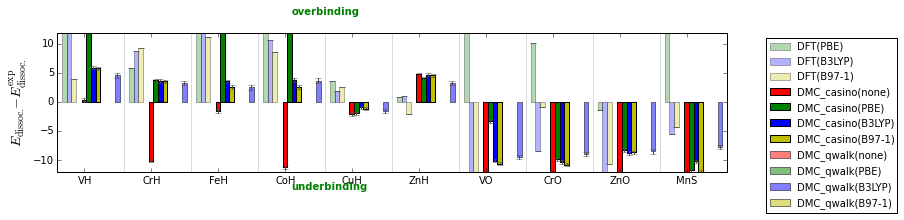

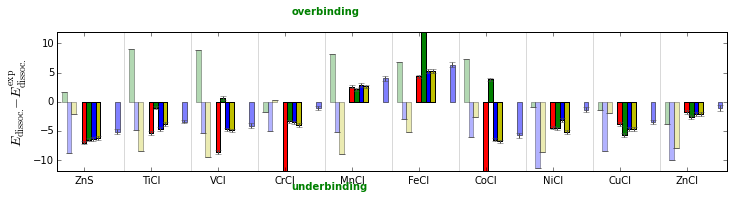

In [22]:
#plot dissoc energy results
typForPlot=[0,2,4]
molPerPlot=min(11, len(compoundListMol))
colors=['r','g','b','y','c','m']
edgecolors=['r','g','b','y','c','m']
opac=[0.3,1,0.5]
error_config = {'ecolor': '0.3'}
barwidth=1/(4*len(typForPlot)*1.2)
#barwidth=0.2
index = numpy.arange(molPerPlot)

for l in range(int(ceil(float(len(compoundListMol))/molPerPlot))):#range(int(len(compoundListMol)/molPerPlot)+1):
    a=l*(molPerPlot-1)
    b=min((l+1)*(molPerPlot-1), len(compoundListMol))
    fig, ax = plt.subplots(figsize=(13, 6))
    for i in range(len(typForPlot)):
        for j in range(4):
            if i==0 and j==0:
                continue
            rects=plt.bar(index[0:b-a]+(i*(4)+j)*barwidth+0.1*4*len(typForPlot)*barwidth*i,
                          (dissocEnergy[a:b,typForPlot[i]*(len(dfttypList))+j]-dissocEnergyExp[a:b]), 
                          barwidth,
                          label=typList[typForPlot[i]]+"("+dfttypList[j]+")",
                          color=colors[j],
                          alpha=opac[i],
                          linewidth=1,
                          yerr=dissocError[a:b,typForPlot[i]*(len(dfttypList))+j],
                          error_kw=error_config,)
    for k in range(b-a):
        plt.axvline(x=k, color='0.85')
    plt.xticks(index+0.4, compoundListMol[a:b])
    #plt.xlabel('Molecules, Methods')                                                                                                     
    plt.ylabel(r'$E_\mathrm{dissoc.}-E_\mathrm{dissoc.}^\mathrm{exp}$', fontsize=14) 
    if l==0:
        #plt.title('dissoc. energies grouped by molecules and methods')   
        plt.legend(loc=2,bbox_to_anchor=(1.05, 1), prop={'size':10})#(loc='best',prop={'size':8})
    plt.autoscale( enable=True,axis=u'both', tight=True)
    ax.text(real(molPerPlot-4)/2.0, 15, "overbinding", fontsize=10,color='green',fontweight='bold')
    ax.text(real(molPerPlot-4)/2.0, -15, "underbinding", fontsize=10,color='green',fontweight='bold')
    ylim([-12,12])
    xlim([0,molPerPlot-1])
    fig.set_size_inches(12,2.5)
    #plt.savefig('dissocE'+str(l)+'.svg', format='svg', dpi=300)

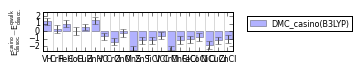

In [23]:
#plot difference in dissoc energy results casino vs. qwalk for DMC(B3LYP)
typForPlot=[2]
RefTypForPlot=[4]
molPerPlot=min(20, len(compoundListMol))
colors=['r','g','b','y','c','m']
edgecolors=['r','g','b','y','c','m']
opac=[0.3,1,0.5]
error_config = {'ecolor': '0.3'}
barwidth=1/(1.2)
#barwidth=0.2
index = numpy.arange(molPerPlot)

for l in range(int(ceil(float(len(compoundListMol))/molPerPlot))):#range(int(len(compoundListMol)/molPerPlot)+1):
    a=l*(molPerPlot-1)
    b=min((l+1)*(molPerPlot-1)+1, len(compoundListMol))
    fig, ax = plt.subplots(figsize=(13, 6))
    for i in range(len(typForPlot)):
        for j in [2]:
            if i==0 and j==0:
                continue
            rects=plt.bar(index[0:b-a]+(i*(4))*barwidth+0.1*4*len(typForPlot)*barwidth*i,
                          (dissocEnergy[a:b,typForPlot[i]*(len(dfttypList))+j]-dissocEnergy[a:b,RefTypForPlot[i]*(len(dfttypList))+j]), 
                          barwidth,
                          label=typList[typForPlot[i]]+"("+dfttypList[j]+")",
                          color=colors[j],
                          alpha=opac[i],
                          linewidth=1,
                          yerr=sqrt(dissocError[a:b,typForPlot[i]*(len(dfttypList))+j]**2+dissocError[a:b,RefTypForPlot[i]*(len(dfttypList))+j]**2),
                          error_kw=error_config,)
    for k in range(b-a):
        plt.axvline(x=k, color='0.85')
    plt.xticks(index+0.4, compoundListMol[a:b], fontsize=8)
    plt.yticks(fontsize=8)
    #plt.xlabel('Molecules, Methods')                                                                                                     
    plt.ylabel(r'$\mathrm{\mathsf{E_{dissoc.}^{casino}-E_{dissoc.}^{qwalk}}}$', fontsize=8) 
    if l==0:
        #plt.title('dissoc. energies grouped by molecules and methods')   
        plt.legend(loc=2,bbox_to_anchor=(1.05, 1), prop={'size':8})#(loc='best',prop={'size':8})
    plt.autoscale( enable=True,axis=u'both', tight=True)
    ylim([-2.6,2.6])
    xlim([0,molPerPlot])
    #fig.set_size_inches(12,2.5)
    fig.set_size_inches(3.4,0.7)
    plt.savefig('dissocE_casinoVsQwalk'+str(l)+'.svg', format='svg', dpi=600)

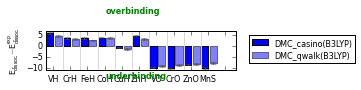

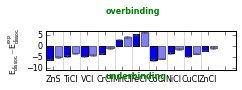

In [24]:
#plot dissoc energy results casino vs qwalk for B3LYP
typForPlot=[2,4]
molPerPlot=min(11, len(compoundListMol))
colors=['r','g','b','y','c','m']
edgecolors=['r','g','b','y','c','m']
opac=[1,0.5]
error_config = {'ecolor': '0.3'}
barwidth=1/(len(typForPlot)*1.2)
#barwidth=0.2
index = numpy.arange(molPerPlot)

for l in range(int(ceil(float(len(compoundListMol))/molPerPlot))):#range(int(len(compoundListMol)/molPerPlot)+1):
    a=l*(molPerPlot-1)
    b=min((l+1)*(molPerPlot-1), len(compoundListMol))
    fig, ax = plt.subplots(figsize=(13, 6))
    for i in range(len(typForPlot)):
        for j in [2]:
            if i==0 and j==0:
                continue
            rects=plt.bar(index[0:b-a]+(i)*barwidth+0.1*len(typForPlot)*barwidth*i,
                          (dissocEnergy[a:b,typForPlot[i]*(len(dfttypList))+j]-dissocEnergyExp[a:b]), 
                          barwidth,
                          label=typList[typForPlot[i]]+"("+dfttypList[j]+")",
                          color=colors[j],
                          alpha=opac[i],
                          linewidth=1,
                          yerr=dissocError[a:b,typForPlot[i]*(len(dfttypList))+j],
                          error_kw=error_config,)
    for k in range(b-a):
        plt.axvline(x=k, color='0.85')
    plt.xticks(index+0.4, compoundListMol[a:b], fontsize=8)
    plt.yticks(fontsize=8)
    #plt.xlabel('Molecules, Methods')                                                                                                     
    plt.ylabel(r'$\mathrm{\mathsf{E_{dissoc.}-E_{dissoc.}^{exp}}}$', fontsize=8) 
    if l==0:
        #plt.title('dissoc. energies grouped by molecules and methods')   
        plt.legend(loc=2,bbox_to_anchor=(1.05, 1), prop={'size':8})#(loc='best',prop={'size':8})
    plt.autoscale( enable=True,axis=u'both', tight=True)
    ax.text(real(molPerPlot-4)/2.0, 15, "overbinding", fontsize=8,color='green',fontweight='bold')
    ax.text(real(molPerPlot-4)/2.0, -15, "underbinding", fontsize=8,color='green',fontweight='bold')
    ylim([-11,7])
    xlim([0,molPerPlot])
    #fig.set_size_inches(12,2.5)
    fig.set_size_inches(3.4,0.7)
    plt.savefig('dissocE_casinoAndQwalk'+str(l)+'.svg', format='svg', dpi=600)

0
20
['VH', 'CrH', 'FeH', 'CoH', 'CuH', 'ZnH', 'VO', 'CrO', 'ZnO', 'MnS', 'ZnS', 'TiCl', 'VCl', 'CrCl', 'MnCl', 'FeCl', 'CoCl', 'NiCl', 'CuCl', 'ZnCl']
[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.]


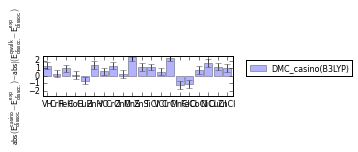

In [25]:
#plot dissoc energy results abs(casino-exp)-abs(qwalk-exp) for B3LYP
typForPlot=[2]
RefTypForPlot=[4]
molPerPlot=min(20, len(compoundListMol))
colors=['r','g','b','y','c','m']
edgecolors=['r','g','b','y','c','m']
opac=[0.3,1,0.5]
error_config = {'ecolor': '0.3'}
barwidth=1/(1.2)
#barwidth=0.2
index = numpy.arange(molPerPlot)

for l in range(int(ceil(float(len(compoundListMol))/molPerPlot))):#range(int(len(compoundListMol)/molPerPlot)+1):
    a=l*(molPerPlot-1)
    b=min((l+1)*(molPerPlot-1)+1, len(compoundListMol))
    print a
    print b
    print compoundListMol[a:b]
    fig, ax = plt.subplots(figsize=(13, 6))
    for i in range(len(typForPlot)):
        for j in [2]:
            if i==0 and j==0:
                continue
            print index[0:b-a]+(i*(4))*barwidth+0.1*4*len(typForPlot)*barwidth*i
            rects=plt.bar(index[0:b-a]+(i*(4))*barwidth+0.1*4*len(typForPlot)*barwidth*i,
                          (abs(dissocEnergy[a:b,typForPlot[i]*(len(dfttypList))+j]-dissocEnergyExp[a:b])-abs(dissocEnergy[a:b,RefTypForPlot[i]*(len(dfttypList))+j]-dissocEnergyExp[a:b])), 
                          barwidth,
                          label=typList[typForPlot[i]]+"("+dfttypList[j]+")",
                          color=colors[j],
                          alpha=opac[i],
                          linewidth=1,
                          yerr=sqrt(dissocError[a:b,typForPlot[i]*(len(dfttypList))+j]**2+dissocError[a:b,RefTypForPlot[i]*(len(dfttypList))+j]**2),
                          error_kw=error_config,)
    plt.xticks(index+0.4, compoundListMol[a:b], fontsize=8)
    plt.yticks(fontsize=8)
    #plt.xlabel('Molecules, Methods')                                                                                                     
    plt.ylabel(r'$\mathrm{\mathsf{abs(E_{dissoc.}^{casino}-E_{dissoc.}^{exp})-abs|(E_{dissoc.}^{qwalk}-E_{dissoc.}^{exp})}}$', fontsize=8) 
    if l==0:
        #plt.title('dissoc. energies grouped by molecules and methods')   
        plt.legend(loc=2,bbox_to_anchor=(1.05, 1), prop={'size':8})#(loc='best',prop={'size':8})
    plt.autoscale( enable=True,axis=u'both', tight=True)
    ylim([-2.6,2.6])
    xlim([0,molPerPlot])
    #fig.set_size_inches(12,2.5)
    fig.set_size_inches(3.4,0.7)
    plt.savefig('dissocE_casinoAndQwalkVsExp'+str(l)+'.svg', format='svg', dpi=600)

In [26]:
#print the energy differences for DMC for casino
typ=2
for compound in range(len(compoundListMol)):
    print(compoundListMol[compound])
    print(dissocEnergy[compound,typ*(len(dfttypList)):typ*len(dfttypList)+4]-dissocEnergyExp[compound])
    print(dissocError[compound,typ*(len(dfttypList)):typ*len(dfttypList)+4])

VH
[  0.38369414  12.70239242   5.97063163   5.82404839]
[ 0.27404801  0.30439037  0.2805923   0.29792084]
CrH
[-10.03921751   3.79923606   3.63820576   3.59839676]
[ 0.3102567   0.28723633  0.29553906  0.29706469]
FeH
[ -1.5097563   12.93786664   3.60986216   2.60885935]
[ 0.30022926  0.29612318  0.29995247  0.29523293]
CoH
[-11.14711021  14.63442939   3.8040957    2.66768259]
[ 0.28328224  0.27294249  0.29788765  0.31717434]
CuH
[-2.08185493 -1.9176106  -0.88309309 -1.0774517 ]
[ 0.3001759   0.30056841  0.2942426   0.28137976]
ZnH
[ 4.81860643  4.15511184  4.73191554  4.62210162]
[ 0.27996611  0.27840606  0.28740183  0.30447124]
VO
[-39.27466988  -3.25193655 -10.05333229 -10.57048538]
[ 0.30107727  0.31657737  0.26755746  0.28611255]
CrO
[-46.53584521  -9.81858036 -10.25546526 -10.71312921]
[ 0.3064683   0.31826693  0.30445173  0.2862611 ]
ZnO
[-13.99363907  -8.25531456  -8.69476591  -8.62909161]
[ 0.30146114  0.32342946  0.29974697  0.3095313 ]
MnS
[-21.61591361 -11.71169747 -10.179

In [27]:
#print the energy differences for DMC for qwalk
typ=4
for compound in range(len(compoundListMol)):
    print(compoundListMol[compound])
    print(dissocEnergy[compound,typ*(len(dfttypList)):typ*len(dfttypList)+4]-dissocEnergyExp[compound])
    print(dissocError[compound,typ*(len(dfttypList)):typ*len(dfttypList)+4])

VH
[        nan         nan  4.62365806         nan]
[        nan         nan  0.38848136         nan]
CrH
[        nan         nan  3.33997893         nan]
[        nan         nan  0.38346141         nan]
FeH
[        nan         nan  2.58105802         nan]
[        nan         nan  0.38002532         nan]
CoH
[        nan         nan  3.70874586         nan]
[        nan         nan  0.44925193         nan]
CuH
[        nan         nan -1.48532889         nan]
[        nan         nan  0.30755189         nan]
ZnH
[        nan         nan  3.27041051         nan]
[        nan         nan  0.37998468         nan]
VO
[        nan         nan -9.40628063         nan]
[        nan         nan  0.39829587         nan]
CrO
[        nan         nan -8.86347194         nan]
[        nan         nan  0.39769395         nan]
ZnO
[       nan        nan -8.4109913        nan]
[        nan         nan  0.42954593         nan]
MnS
[        nan         nan -7.71736957         nan]
[        nan    

In [28]:
#print the energy differences for DFT
typ=0
for compound in range(len(compoundListMol)):
    print(compoundListMol[compound])
    print(dissocEnergy[compound,typ*(len(dfttypList)):typ*len(dfttypList)+4]-dissocEnergyExp[compound])
    print(dissocError[compound,typ*(len(dfttypList)):typ*len(dfttypList)+4])

VH
[ -9.74921131  20.61942697  12.40668985   3.97302008]
[ 0.  0.  0.  0.]
CrH
[-18.54812048   5.9613349    8.86437287   9.35095148]
[ 0.  0.  0.  0.]
FeH
[-13.24175061  18.26059341  12.51996226  11.28387463]
[ 0.  0.  0.  0.]
CoH
[-22.87718577  16.71500509  10.68195578   8.64470266]
[ 0.  0.  0.  0.]
CuH
[-28.9415186    3.7081675    2.01316716   2.56068467]
[ 0.  0.  0.  0.]
ZnH
[-2.26066593  0.82610905  1.12397211 -1.943816  ]
[ 0.  0.  0.  0.]
VO
[-112.22469394   21.27378667  -12.26812723  -16.16385189]
[ 0.  0.  0.  0.]
CrO
[-93.15394362  10.14692343  -8.43005838  -0.77224293]
[ 0.  0.  0.  0.]
ZnO
[-82.00833591  -1.24675586 -16.9061561  -10.5459054 ]
[ 0.  0.  0.  0.]
MnS
[-50.56966079  18.91336459  -5.45919562  -4.24965096]
[ 0.  0.  0.  0.]
ZnS
[-40.27173463   1.57492041  -8.8546029   -2.11613007]
[ 0.  0.  0.  0.]
TiCl
[-20.16468378   9.02825162  -4.82560863  -8.41448022]
[ 0.  0.  0.  0.]
VCl
[-23.47155672   8.82414261  -5.42864564  -9.51682976]
[ 0.  0.  0.  0.]
CrCl
[-26.231

In [29]:
#calculate variance in the dissoc energy for DFT and DMC after DFT (without HF):
var=zeros(5)

for typ in [0,2,4]:
    n=0
    molNan=0
    for compound in range(len(compoundListMol)):
        if any(np.isnan(dissocEnergy[compound, 1:4])) or any(np.isnan(dissocEnergy[compound, 11:14])):
            molNan+=1
            continue
        else:
            var[typ]+=sum((dissocEnergy[compound, 1+typ*len(dfttypList):4+typ*len(dfttypList)]
                       -mean(dissocEnergy[compound, 1+typ*len(dfttypList):4+typ*len(dfttypList)]))**2)
            n+=1
            print(compoundListMol[compound])
            print(sqrt(sum((dissocEnergy[compound, 1+typ*len(dfttypList):4+typ*len(dfttypList)]
                       -mean(dissocEnergy[compound, 1+typ*len(dfttypList):4+typ*len(dfttypList)]))**2)/3))
    var[typ]=var[typ]/(n*3-n)

print(var)

VH
6.79606666889
CrH
1.49643609084
FeH
3.03968864484
CoH
3.42665800004
CuH
0.70628279025
ZnH
1.38132509168
VO
16.8054668352
CrO
7.62287919273
ZnO
6.43034288666
MnS
11.2151186595
ZnS
4.31799627331
TiCl
7.52077372737
VCl
7.86162613879
CrCl
2.18395421098
MnCl
7.38213613562
FeCl
5.25863762273
CoCl
5.65112483526
NiCl
4.39623921536
CuCl
3.18630175704
ZnCl
2.63201796804
VH
3.20849058739
CrH
0.0868280136181
FeH
4.65118940258
CoH
5.39331470265
CuH
0.448933146694
ZnH
0.250075781418
VO
3.33479281851
CrO
0.365230880865
ZnO
0.193545825153
MnS
0.775912191667
ZnS
0.126010172511
TiCl
1.54630442771
VCl
2.58686653794
CrCl
0.259411896768
MnCl
0.322879882503
FeCl
4.14710394078
CoCl
4.96822430139
NiCl
0.849612898132
CuCl
0.476657184768
ZnCl
0.227423531103
VH
nan
CrH
nan
FeH
nan
CoH
nan
CuH
nan
ZnH
nan
VO
nan
CrO
nan
ZnO
nan
MnS
nan
ZnS
nan
TiCl
nan
VCl
nan
CrCl
nan
MnCl
nan
FeCl
nan
CoCl
nan
NiCl
nan
CuCl
nan
ZnCl
nan
[ 65.38109637   0.           9.40005168   0.                  nan]


In [30]:
#calculate variance in the dissoc energy for DFT and DMC after DFT (without HF) and without VO, VH, and FeH, FeCl, CoH, CoCl(bad PBE):
var=zeros(5)
for typ in [0,2,4]:
    n=0
    molNan=0
    for compound in range(len(compoundListMol)):
        if any(np.isnan(dissocEnergy[compound, 1:4])) or any(np.isnan(dissocEnergy[compound, 11:14])):
            molNan+=1
            continue
        if 'V' in compoundListMol[compound] or 'Fe' in compoundListMol[compound] or 'Co' in compoundListMol[compound]:
            continue
        else:
            var[typ]+=sum((dissocEnergy[compound, 1+typ*len(dfttypList):4+typ*len(dfttypList)]
                       -mean(dissocEnergy[compound, 1+typ*len(dfttypList):4+typ*len(dfttypList)]))**2)
            n+=1
            #print(compoundListMol[compound])
            #print(sqrt(sum((dissocEnergy[compound, 1+typ*len(dfttypList):4+typ*len(dfttypList)]
            #           -mean(dissocEnergy[compound, 1+typ*len(dfttypList):4+typ*len(dfttypList)]))**2)/3))
    print(n)
    var[typ]=var[typ]/(n*3-n)

print(var)

13
13
13
[ 46.24181246   0.           0.53351063   0.                  nan]


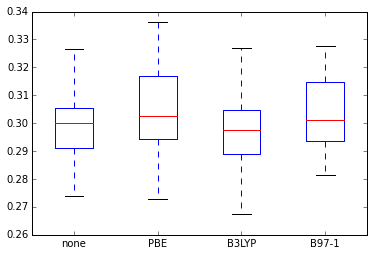

In [31]:
#analyze errorbars of dissocEnergy casino
typ=2
boxplot(dissocError[:,typ*len(dfttypList):4+typ*len(dfttypList)])
plt.xticks([1,2,3,4], dfttypList);

/opt/rh/python27/root/usr/lib64/python2.7/site-packages/numpy/lib/function_base.py:3403: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)
/opt/rh/python27/root/usr/lib64/python2.7/site-packages/matplotlib/cbook.py:2028: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = np.compress(x <= hival, x)
/opt/rh/python27/root/usr/lib64/python2.7/site-packages/matplotlib/cbook.py:2035: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = np.compress(x >= loval, x)
/opt/rh/python27/root/usr/lib64/python2.7/site-packages/matplotlib/cbook.py:2043: RuntimeWarning: invalid value encountered in less
  np.compress(x < stats['whislo'], x),
/opt/rh/python27/root/usr/lib64/python2.7/site-packages/matplotlib/cbook.py:2044: RuntimeWarning: invalid value encountered in greater
  np.compress(x > stats['whishi'], x)


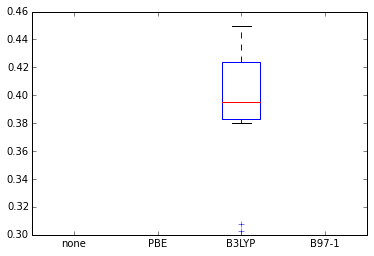

In [32]:
#analyze errorbars of dissocEnergy qwalk
typ=4
boxplot(dissocError[:,typ*len(dfttypList):4+typ*len(dfttypList)])
plt.xticks([1,2,3,4], dfttypList);

In [33]:
#calculate all mean unsigned errors
for i in [0,2,4]:#range(len(typList)):
    for j in range(len(dfttypList)):
        print("{} {}: {}".format(typList[i],dfttypList[j],nanmean(abs(dissocEnergy[:,j+i*len(dfttypList)]-dissocEnergyExp))))
        print(np.count_nonzero(~np.isnan(dissocEnergy[:,j+i*len(dfttypList)])))


DFT none: 35.152901637
20
DFT PBE: 8.37499005305
20
DFT B3LYP: 7.94827286465
20
DFT B97-1: 6.26428939509
20
DFT M06: 5.57065754515
10
DMC_casino none: 11.1736197825
20
DMC_casino PBE: 6.3891722223
20
DMC_casino B3LYP: 5.29770708029
20
DMC_casino B97-1: 5.40296786968
20
DMC_casino M06: nan
0
DMC_qwalk none: nan
0
DMC_qwalk PBE: nan
0
DMC_qwalk B3LYP: 4.47733269128
20
DMC_qwalk B97-1: nan
0
DMC_qwalk M06: nan
0


/opt/rh/python27/root/usr/lib64/python2.7/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


In [34]:
#calculate all mean signed errors
for i in [0,2,4]:#range(len(typList)):
    for j in range(len(dfttypList)):
        print("{} {}: {}".format(typList[i],dfttypList[j],nanmean(dissocEnergy[:,j+i*len(dfttypList)]-dissocEnergyExp)))
        print(np.count_nonzero(~np.isnan(dissocEnergy[:,j+i*len(dfttypList)])))


DFT none: -35.152901637
20
DFT PBE: 7.4432819373
20
DFT B3LYP: -3.18726086127
20
DFT B97-1: -2.65844040466
20
DFT M06: -2.05776736496
10
DMC_casino none: -9.96564030787
20
DMC_casino PBE: 0.498264417584
20
DMC_casino B3LYP: -2.30622035775
20
DMC_casino B97-1: -2.68209357927
20
DMC_casino M06: nan
0
DMC_qwalk none: nan
0
DMC_qwalk PBE: nan
0
DMC_qwalk B3LYP: -1.68471037737
20
DMC_qwalk B97-1: nan
0
DMC_qwalk M06: nan
0


In [35]:
#calculate  standard deviation of the mean of the errors
for i in [0,2,4]:#range(len(typList)):
    for j in range(len(dfttypList)-1):
        mue=nanmean(abs(dissocEnergy[:,j+i*len(dfttypList)]-dissocEnergyExp))
        n=0
        var=0
        for k in range(len(compoundListMol)):
            if isnan(dissocEnergy[k,j+i*len(dfttypList)]):
                continue
            n+=1
            var+=(abs(dissocEnergy[k,j+i*len(dfttypList)]-dissocEnergyExp[k])-mue)**2
        if not n==0:
            print("{} {}: {}".format(typList[i],dfttypList[j],sqrt(var/(n-1)/n)))
            print(np.count_nonzero(~np.isnan(dissocEnergy[:,j+i*len(dfttypList)])))


DFT none: 6.96470755771
20
DFT PBE: 1.58095802527
20
DFT B3LYP: 0.90972092385
20
DFT B97-1: 0.955697485044
20
DMC_casino none: 2.77523549907
20
DMC_casino PBE: 1.03660667931
20
DMC_casino B3LYP: 0.602394815594
20
DMC_casino B97-1: 0.673038129588
20
DMC_qwalk B3LYP: 0.575089488697
20


In [36]:
#calculate corrected sample standard deviation of the errors
for i in [0,2,4]:#range(len(typList)):
    for j in range(len(dfttypList)):
        mue=nanmean(abs(dissocEnergy[:,j+i*len(dfttypList)]-dissocEnergyExp))
        n=0
        var=0
        for k in range(len(compoundListMol)):
            if isnan(dissocEnergy[k,j+i*len(dfttypList)]):
                continue
            n+=1
            var+=(abs(dissocEnergy[k,j+i*len(dfttypList)]-dissocEnergyExp[k])-mue)**2
        
        print("{} {}: {}".format(typList[i],dfttypList[j],sqrt(var/(n-1))))
        print(np.count_nonzero(~np.isnan(dissocEnergy[:,j+i*len(dfttypList)])))


DFT none: 31.1471190849
20
DFT PBE: 7.07025922815
20
DFT B3LYP: 4.06839565257
20
DFT B97-1: 4.27400908497
20
DFT M06: 6.30097761572
10
DMC_casino none: 12.411230459
20
DMC_casino PBE: 4.63584600175
20
DMC_casino B3LYP: 2.69399151392
20
DMC_casino B97-1: 3.00991801842
20
DMC_casino M06: 0.0
0
DMC_qwalk none: 0.0
0
DMC_qwalk PBE: 0.0
0
DMC_qwalk B3LYP: 2.57187837974
20
DMC_qwalk B97-1: 0.0
0
DMC_qwalk M06: 0.0
0


In [37]:
#calculate all mean errors for the mols which are converged in HF, PBE, B3LY and B97-1 and without V..., Fe...,  and Co... (bad PBE)
dissocEnergyAllConv=zeros([len(compoundListMol), 5*len(dfttypList)])
for i in range(len(compoundListMol)):
    if any([isnan(dissocEnergy[i, j]) for j in range(4)])  or any([isnan(dissocEnergy[i,2*len(dfttypList)+j:2*len(dfttypList)+j]) for j in range(4)]) or any([isnan(dissocEnergy[i,4*len(dfttypList)+j:4*len(dfttypList)+j]) for j in range(4)]) or 'V' in compoundListMol[i] or 'Fe' in compoundListMol[i] or 'Co' in compoundListMol[i]:
        dissocEnergyAllConv[i, 0:4]=None
        dissocEnergyAllConv[i,2*len(dfttypList):2*len(dfttypList)+4]=None
        dissocEnergyAllConv[i,4*len(dfttypList):4*len(dfttypList)+4]=None
    else:
        dissocEnergyAllConv[i, 0:4]=dissocEnergy[i, 0:4]
        dissocEnergyAllConv[i,2*len(dfttypList):2*len(dfttypList)+4]=dissocEnergy[i,2*len(dfttypList):2*len(dfttypList)+4]
        dissocEnergyAllConv[i,4*len(dfttypList):4*len(dfttypList)+4]=dissocEnergy[i,4*len(dfttypList):4*len(dfttypList)+4]
for i in [0,2,4]:#range(len(typList)):
    for j in range(4):
        print("{} {}: {}".format(typList[i],dfttypList[j],nanmean(abs(dissocEnergyAllConv[:,j+i*len(dfttypList)]-dissocEnergyExp))))
        print(np.count_nonzero(~np.isnan(dissocEnergyAllConv[:,j+i*len(dfttypList)])))

DFT none: 37.0677906312
13
DFT PBE: 5.20480554841
13
DFT B3LYP: 7.43388904149
13
DFT B97-1: 5.21792079888
13
DMC_casino none: 10.7833872175
13
DMC_casino PBE: 5.05388889015
13
DMC_casino B3LYP: 5.07165929649
13
DMC_casino B97-1: 5.33105422166
13
DMC_qwalk none: nan
0
DMC_qwalk PBE: nan
0
DMC_qwalk B3LYP: 4.07010870662
13
DMC_qwalk B97-1: nan
0


In [38]:
#calculate  standard deviation of the mean of the errors without V..., Fe..., and Co...(bad PBE)
for i in [0,2,4]:#range(len(typList)):
    for j in range(len(dfttypList)-1):
        mue=nanmean(abs(dissocEnergy[:,j+i*len(dfttypList)]-dissocEnergyExp))
        n=0
        var=0
        for k in range(len(compoundListMol)):
            if isnan(dissocEnergy[k,j+i*len(dfttypList)])or any([isnan(dissocEnergy[k,2*len(dfttypList)+j:2*len(dfttypList)+j]) for j in range(4)]) or 'V' in compoundListMol[k] or 'Fe' in compoundListMol[k] or 'Co' in compoundListMol[k]:
                continue
            n+=1
            var+=(abs(dissocEnergy[k,j+i*len(dfttypList)]-dissocEnergyExp[k])-mue)**2
        if not n==0:
            print("{} {}: {}".format(typList[i],dfttypList[j],sqrt(var/(n-1)/n)))
            print(n)

DFT B97-1: 8.70567837338
13
DFT B97-1: 1.39433496056
13
DFT B97-1: 1.31712363107
13
DFT B97-1: 1.09764295768
13
DMC_casino B97-1: 1.91374292355
13
DMC_casino B97-1: 0.954506203032
13
DMC_casino B97-1: 0.904363654183
13
DMC_casino B97-1: 0.904550669716
13


In [39]:
#calculate mean errors for single Det character mols:
for i in [0,2,4]:#range(len(typList)):
    for j in range(len(dfttypList)):
        print("{} {}: {}".format(typList[i],dfttypList[j],nanmean([abs(dissocEnergy[k,j+i*len(dfttypList)]-dissocEnergyExp[k]) for k in range(len(compoundListMol)) if compoundListMol[k] in ['CuCl', 'ZnH', 'ZnS', 'ZnCl', 'CrCl', 'MnCl', 'FeCl']])))
        print(np.count_nonzero(~np.isnan([dissocEnergy[k,j+i*len(dfttypList)]for k in range(len(compoundListMol)) if compoundListMol[k] in ['CuCl', 'ZnH', 'ZnS', 'ZnCl', 'CrCl', 'MnCl', 'FeCl']])))


DFT none: 17.7001654363
7
DFT PBE: 3.50041499013
7
DFT B3LYP: 5.96109790465
7
DFT B97-1: 4.08185574256
7
DFT M06: 4.39833883986
4
DMC_casino none: 5.77235242814
7
DMC_casino PBE: 5.51606111246
7
DMC_casino B3LYP: 4.24619557648
7
DMC_casino B97-1: 4.23013333378
7
DMC_casino M06: nan
0
DMC_qwalk none: nan
0
DMC_qwalk PBE: nan
0
DMC_qwalk B3LYP: 3.51312350073
7
DMC_qwalk B97-1: nan
0
DMC_qwalk M06: nan
0


In [40]:
#calculate mean errors for multi Det character mols:
for i in [0,2,4]:#range(len(typList)):
    for j in range(len(dfttypList)):
        print("{} {}: {}".format(typList[i],dfttypList[j],nanmean([abs(dissocEnergy[k,j+i*len(dfttypList)]-dissocEnergyExp[k]) for k in range(len(compoundListMol)) if not compoundListMol[k] in ['CuCl', 'ZnH', 'ZnS', 'ZnCl', 'CrCl', 'MnCl', 'FeCl']])))
        print(np.count_nonzero(~np.isnan([dissocEnergy[k,j+i*len(dfttypList)]for k in range(len(compoundListMol)) if not compoundListMol[k] in ['CuCl', 'ZnH', 'ZnS', 'ZnCl', 'CrCl', 'MnCl', 'FeCl']])))


DFT none: 44.5505288219
13
DFT PBE: 10.9997612408
13
DFT B3LYP: 9.0182901508
13
DFT B97-1: 7.43944597722
13
DFT M06: 6.35220334869
6
DMC_casino none: 14.0819945118
13
DMC_casino PBE: 6.85930897375
13
DMC_casino B3LYP: 5.86390558235
13
DMC_casino B97-1: 6.03449415824
13
DMC_casino M06: nan
0
DMC_qwalk none: nan
0
DMC_qwalk PBE: nan
0
DMC_qwalk B3LYP: 4.99652225543
13
DMC_qwalk B97-1: nan
0
DMC_qwalk M06: nan
0


In [41]:
#calculate mean errors for mols with exp error <1.2kcal/mol (['FeH', 'NiCl', 'CuCl', 'CoH', 'CrO', ZnH', 'ZnO', 'ZnS', 'ZnCl'])
for i in [0,2,4]:#range(len(typList)):
    for j in range(len(dfttypList)):
        print("{} {}: {}".format(typList[i],dfttypList[j],nanmean([abs(dissocEnergy[k,j+i*len(dfttypList)]-dissocEnergyExp[k]) for k in range(len(compoundListMol)) if not compoundListMol[k] in ['FeH', 'NiCl', 'CuCl', 'CoH', 'CrO','ZnH', 'ZnO', 'ZnS', 'ZnCl']])))
        print(np.count_nonzero(~np.isnan([dissocEnergy[k,j+i*len(dfttypList)]for k in range(len(compoundListMol)) if not compoundListMol[k] in ['FeH', 'NiCl', 'CuCl', 'CoH', 'CrO','ZnH', 'ZnO', 'ZnS', 'ZnCl']])))

DFT none: 30.7171523752
11
DFT PBE: 10.2249667418
11
DFT B3LYP: 6.40856284863
11
DFT B97-1: 6.49119876679
11
DFT M06: 3.37869528595
6
DMC_casino none: 11.664227758
11
DMC_casino PBE: 5.3158910789
11
DMC_casino B3LYP: 5.30934743392
11
DMC_casino B97-1: 5.5019006771
11
DMC_casino M06: nan
0
DMC_qwalk none: nan
0
DMC_qwalk PBE: nan
0
DMC_qwalk B3LYP: 4.68146656287
11
DMC_qwalk B97-1: nan
0
DMC_qwalk M06: nan
0
